In [30]:
from brian2 import *
import sys 
sys.path.append('..')

from DynapSE import DynapSE
from Spike_G import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Display plots inside Jupyter cell
%matplotlib inline 
# Set the dots-per-inch (resolution) of the images
mpl.rcParams['figure.dpi'] = 90
from equations.dynapse_eq import *
from parameters.dynapse_param import *

# C++ code generation for faster spiking network simulation
set_device('cpp_standalone')

# Ignore Brian2 base warnings/dynapse-simulator-New-Parameters/

BrianLogger.suppress_name('base')
# The clock of Brian2 simulation for numerically solve ODEs
defaultclock.dt = 20 * us

In [31]:
adaptation_conf = {
    "Isoma_dpi_tau" :  2.8* pA,
    "Isoma_th"  : 30 * nA,  
    "alpha_soma": 1,

    "Isoma_ahp_tau": 20 * pA,             
    "Isoma_ahp_w" : 3000 * pA,
    
    "alpha_ahp"  : 4,  
    "soma_refP": 1 * ms,
    "Isoma_const": 150 *pA
                  }


ampa_conf = {
        "Iampa_tau": 1 * pA,
        "Iampa_w0":30*pA
            }

nmda_conf = {"Inmda_tau": 5 * pA,
            "alpha_nmda": 4,
            "Inmda_w0": 1 * pA}

In [75]:
def Single_neuron(adaptation_conf,ampa_conf,nmda_conf):
    now = datetime.datetime.now() # current date and time
    date_time = now.strftime("%m_%d_%Y_%H_%M_%S")

    pid = os.getpid()
    print(f'Process {pid} launched, at ' + date_time)

    directory = f"single_neuron_run_{pid}_{date_time}"
            
    set_device('cpp_standalone', directory=directory)

    BrianLogger.suppress_name('base')
    defaultclock.dt = 20 * us

    input_spike_generator=SpikeGen('regular',0,1,1,30,1,'SpikeGenerator')

    inp_duration=1 

    network = Network() # Instantiate a Brian2 Network
    chip = DynapSE(network) # Instantiate a Dynap-SE1 chip implementing neural and synaptic silicon dynamics
    DPI_neuron  = chip.get_neurons(1, 'Core_1') # Allocate single DPI neuron from Core 1
    DPI_NMDA_synapse = chip.add_connection(input_spike_generator, DPI_neuron, synapse_type='NMDA') # Define a slow excitatory synapse
    DPI_AMPA_synapse = chip.add_connection(input_spike_generator, DPI_neuron, synapse_type='AMPA') # Define a fast excitatory synapse

    # In Brian2 creating Synapses instance does not connect two endpoints, it only specifies synaptic dynamics 
    # Let's connect two endpoints and set an initial weight of 0.7.

    chip.connect(DPI_NMDA_synapse, True)
    DPI_NMDA_synapse.weight = 0

    chip.connect(DPI_AMPA_synapse, True)
    DPI_AMPA_synapse.weight = 15

    core_conf = {**ampa_conf,**adaptation_conf,**nmda_conf}
    # set the params
    chip.set_bias(core_conf, 'Core_1')

                
    # Monitors
    mon_neuron_input  = SpikeMonitor(input_spike_generator, name='mon_neuron_input')
    mon_synapse_nmda  = StateMonitor(DPI_NMDA_synapse, 'Inmda', record=[0])
    mon_synapse_ampa  = StateMonitor(DPI_AMPA_synapse, 'Iampa', record=[0])
    mon_neuron_state  = StateMonitor(DPI_neuron, 'Isoma_mem', record=True)
    mon_neuron_output = SpikeMonitor(DPI_neuron, name='mon_neuron_output')

    # Add every instance we created to Brian network, so it will include them in the simulation
    network.add([input_spike_generator,mon_synapse_ampa,DPI_NMDA_synapse,DPI_AMPA_synapse,mon_synapse_nmda,mon_neuron_input])
    network.add([DPI_neuron , mon_neuron_output, mon_neuron_state])
    # Simulation
    network.run(inp_duration * 1000 * ms)


    print('Output firing rate 1 = ', mon_neuron_output.count/ (inp_duration* 1000 * ms))
    print('Membrane Time Constant= ',DPI_neuron.tau_soma)

    Output={
            'duration':inp_duration,
            'time':mon_neuron_state.t/ms,
            'mon_neuron_input_t':mon_neuron_input.t/ms,
            'mon_neuron_output_t':mon_neuron_output.t/ms,
            'mon_synapse_nmda':mon_synapse_nmda[0].Inmda/pA,
            'mon_synapse_ampa':mon_synapse_ampa[0].Iampa/pA,
            'mon_neuron_state':mon_neuron_state[0].Isoma_mem/pA,
            }
    
    device.reinit()
    return Output 




In [76]:
Network_Output=Single_neuron(adaptation_conf,ampa_conf,nmda_conf)

Process 34685 launched, at 07_27_2022_16_49_58
1 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
Output firing rate 1 =  [39.] Hz
Membrane Time Constant=  <Core_1_subgroup_6.tau_soma: array([25.32928065]) * msecond>


After the simulation is completed, we can see how the variables that we monitored evolved. Let's plot input spikes, membrane voltage, and output spikes to understand the neuron's response. 

<Figure size 2400x1050 with 0 Axes>

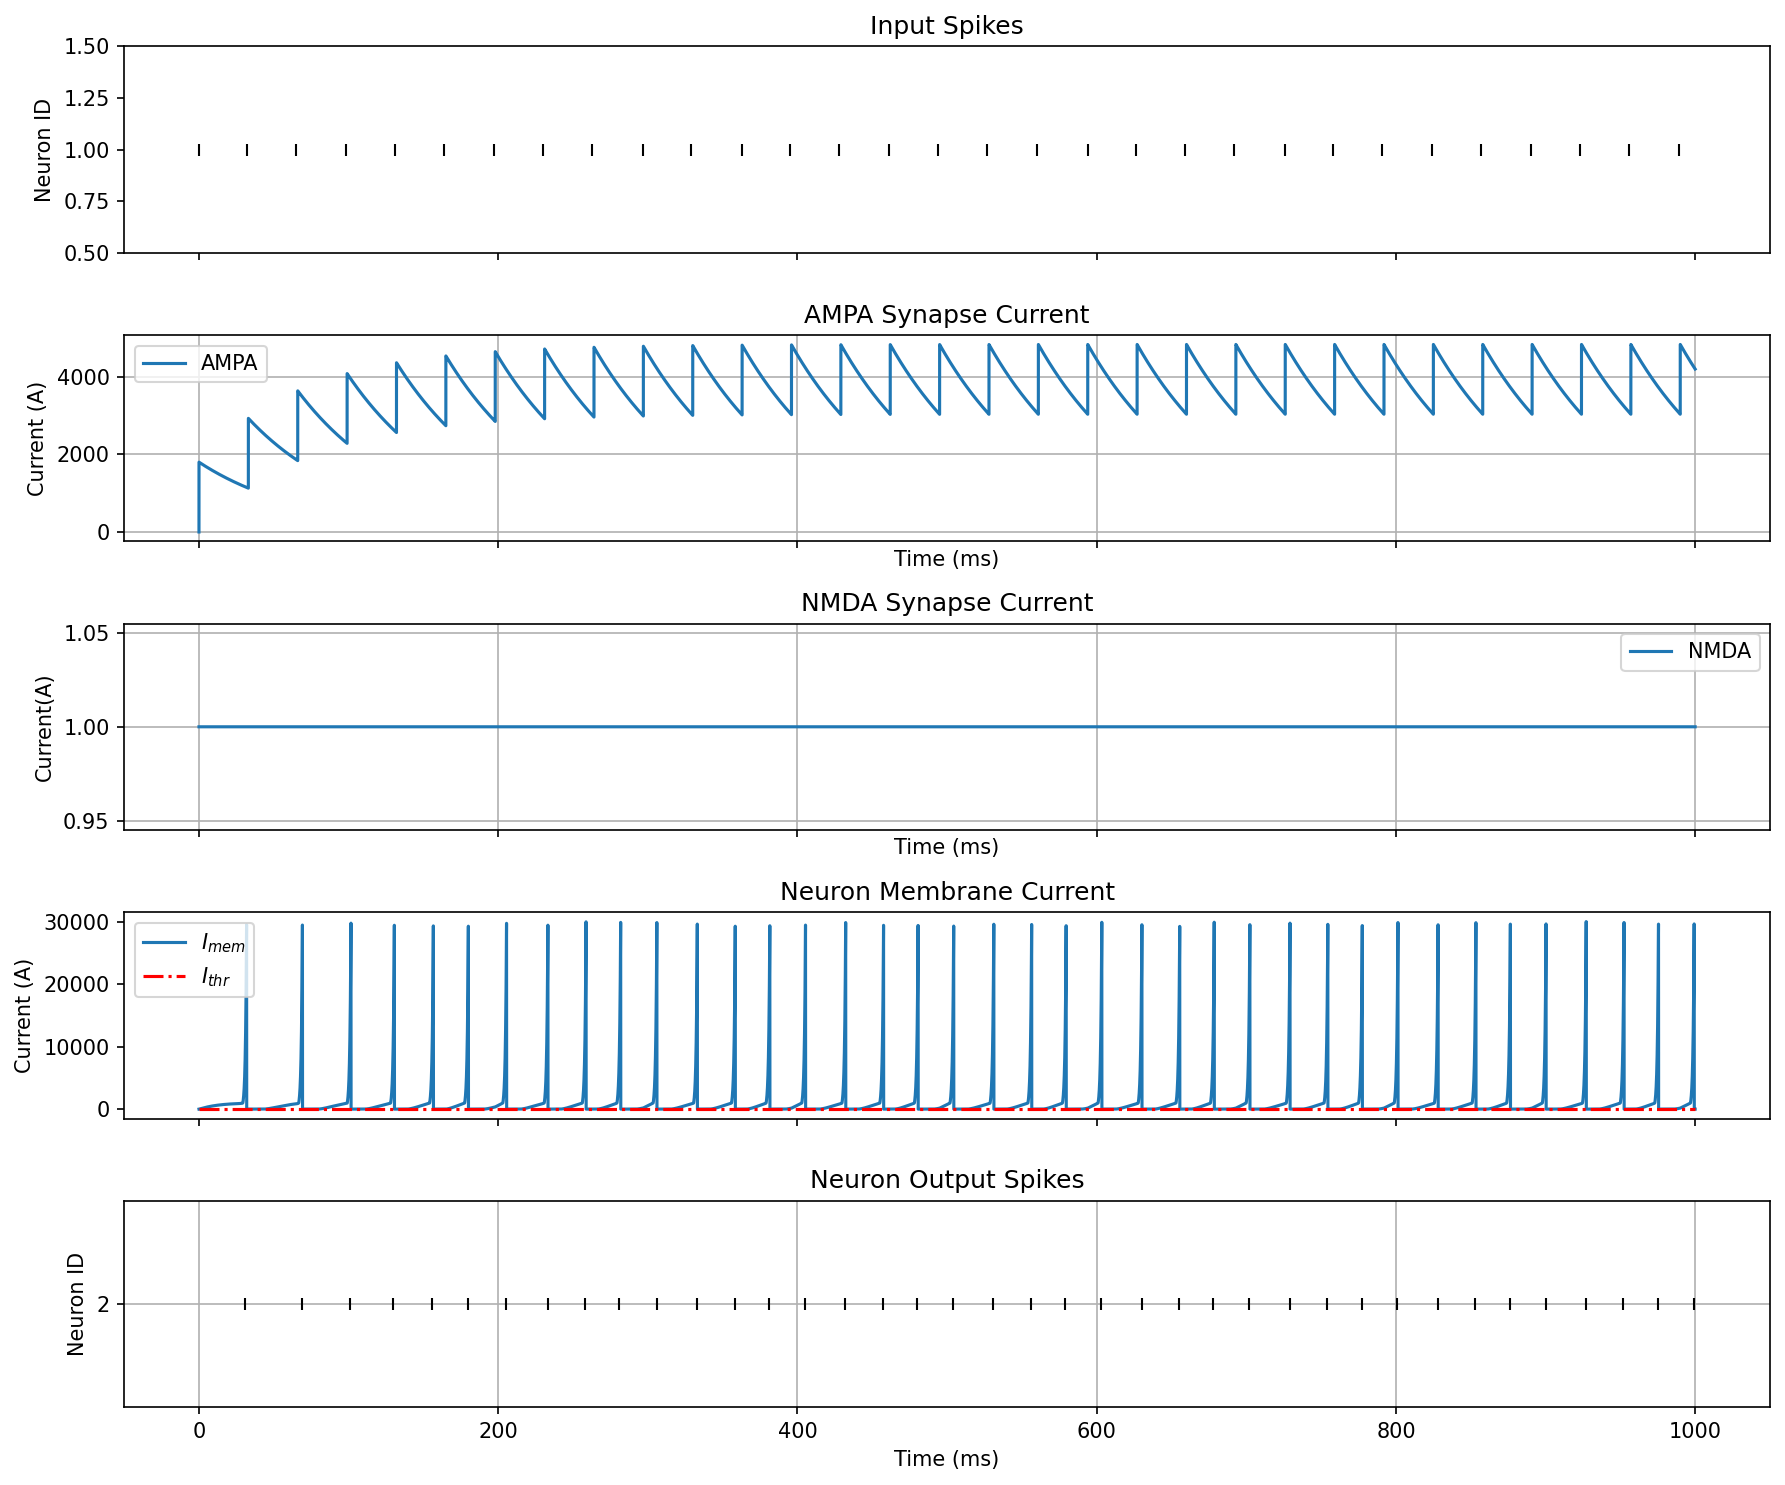

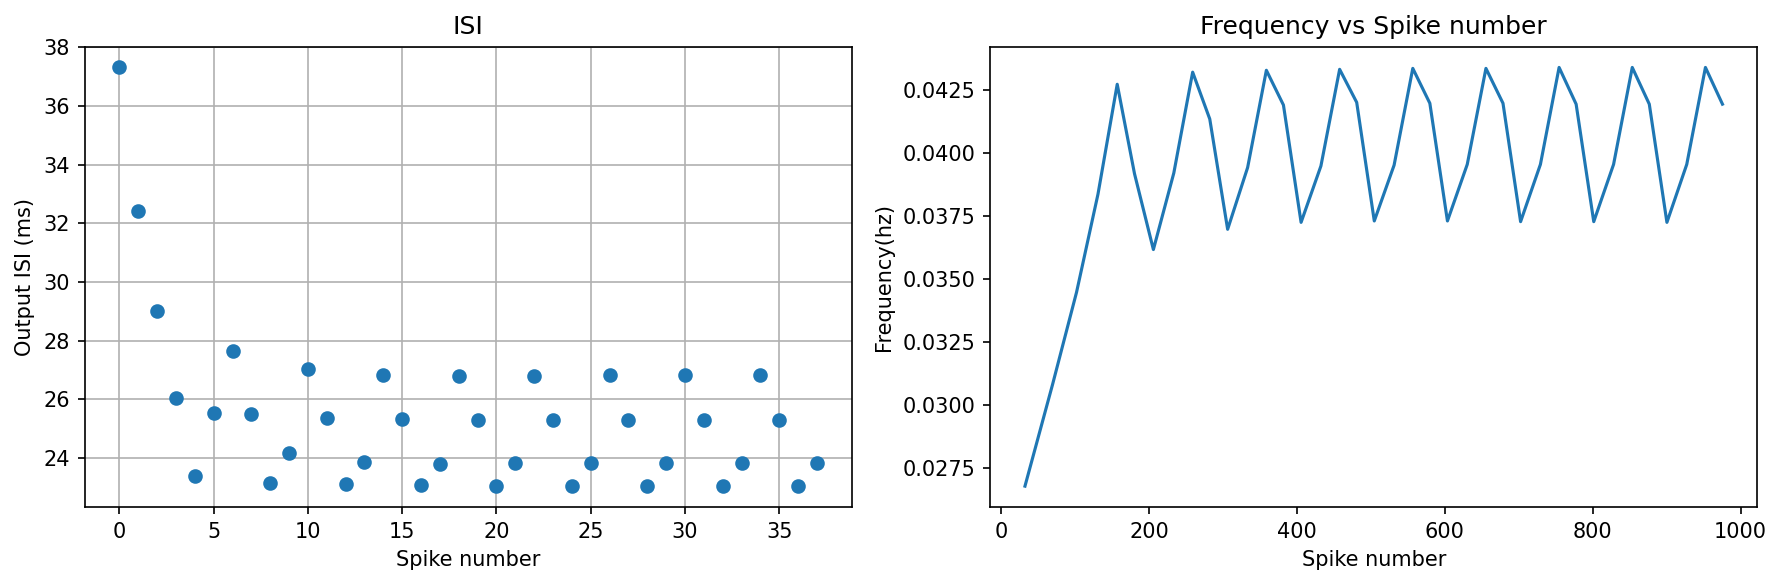

In [77]:
plt.figure(figsize=(16,7),dpi=150)

plt.subplots_adjust(hspace=.5)


inp_duration=Network_Output['duration']


fig1, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1,sharex=True,figsize=(12,10),dpi=150)
    # Input Spikes
spike_placeholder = np.zeros(inp_duration*1000)
spike_placeholder[np.array(Network_Output['mon_neuron_input_t'], dtype=int)]=1 
ax1.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
ax1.set_ylim(0.5, 1.5)
ax1.set_title('Input Spikes')
ax1.set_ylabel('Neuron ID')

ax2.plot(Network_Output['time'], Network_Output['mon_synapse_ampa'], linewidth=1.5)
ax2.legend(['AMPA'])
ax2.set_ylabel('Current (A)')
ax2.set_title('AMPA Synapse Current')
ax2.set_xlabel('Time (ms)')

ax2.grid(True)

ax3.plot(Network_Output['time'], Network_Output['mon_synapse_nmda'], linewidth=1.5)
ax3.legend(['NMDA'])
ax3.set_title('NMDA Synapse Current')
ax3.set_ylabel('Current(A)')
ax3.set_xlabel('Time (ms)')
ax3.grid(True)

ax4.plot(Network_Output['time'], Network_Output['mon_neuron_state'])
ax4.hlines(y=dynapse_param['Isoma_th']*1e-9/nA, xmin=tstart, xmax=tend, color='r', linestyles='-.')
ax4.legend(['$I_{mem}$', '$I_{thr}$'])
ax4.set_title('Neuron Membrane Current')
ax4.set_ylabel('Current (A)')

spike_placeholder = np.zeros(inp_duration*1000)
spike_placeholder[np.array(Network_Output['mon_neuron_output_t'], dtype=int)]=2
ax5.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
ax5.set_title('Neuron Output Spikes')
ax5.set_ylabel('Neuron ID')
ax5.set_xlabel('Time (ms)')
ax5.set_ylim(1.5, 2.5)
ax5.grid()




plt.tight_layout()


fig2, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4),dpi=150)

ax1.plot(np.diff(Network_Output['mon_neuron_output_t']),'o')

ax1.set_title('ISI')
ax1.set_xlabel('Spike number')
ax1.set_ylabel('Output ISI (ms)')

ax1.grid()

ax2.plot(remove_last_element(np.array(Network_Output['mon_neuron_output_t'])),1/(np.diff(Network_Output['mon_neuron_output_t'])))
ax2.set_title('Frequency vs Spike number')
ax2.set_xlabel('Spike number')
ax2.set_ylabel('Frequency(hz)')


plt.tight_layout()



We provided an input spike train to a DPI neuron then observed some output spikes (If input spike parameters are correct). Now, we monitor the output current of DPI synapse that enters to neuron.

Finally, we can observe the membrane current ($I_{mem}$) on silicon neuron and see how synaptic input accumulates and results in spikes.

In [7]:

# Add code here
# to start a new build to run multiple full simulations
tau_list=[10,20,30,40,50]*pA
freq_list=[10,50,100,200,300,500]*Hz
firing_rate=[]
N=10
for tau in tau_list:
    device.reinit()
    device.activate()
    # need to reset the defaultclock after activate
    defaultclock.dt = 20 * us
    
    network = Network()
    chip = DynapSE(network)
    seed(4321)
    # Create a poisson spike generator with 100 Hz
    # Allocate single neuron from Core 1
    DPI_neurons  = chip.get_neurons(len(freq_list), 'Core_1')
    DPI_neurons.Isoma_const = 0 * pA 
    # Define an AMPA synapse to connect the spike generator to the neuron 
    
    # In Brian2 creating a Synapses instance does not create synapses, it only specifies their dynamics.
    # so remember to call connect function to really build the connection
    Spike_Generators=[]
    DPI_synapses=[]
    counter1=0
    counter2=1
    for i in range(len(freq_list)):
        
        Spike_Generators.append(PoissonGroup(1, freq_list[i]))
        DPI_synapses.append(chip.add_connection(Spike_Generators[i],DPI_neurons[counter1:counter2], synapse_type='AMPA'))
        chip.connect(DPI_synapses[i], True)
        DPI_synapses[i].weight = 100 # number of synapse and not weight
        counter1=counter1+1
        counter2=counter2+1
        
        
        
        

    # here we set an initial weight of 200.
    

    ampa_conf_2 = {'Isoma_dpi_tau': tau}

    #increase I_tau
    chip.set_bias(ampa_conf_2,'Core_1')
    chip.set_bias(adaptation_conf,'Core_1')
    chip.set_bias(ampa_conf,'Core_1')

    # monitors
    mon_synapse_state = StateMonitor(DPI_synapses[0], 'Iampa', record=[0]) # it's not I_syn_exc2
    mon_neuron_state  = StateMonitor(DPI_neurons,  'Isoma_mem', record=[0])
    mon_neuron_input  = SpikeMonitor(Spike_Generators[0], name='mon_neuron_input')
    mon_neuron_output = SpikeMonitor(DPI_neurons, name='mon_neuron_output')

    # add all the instances into the network 
    network.add([Spike_Generators, DPI_neurons, DPI_synapses, 
                 mon_synapse_state, mon_neuron_state, mon_neuron_input, mon_neuron_output])

    # Simulation
    duration = .5 * second
    network.run(duration)
    print('Output firing rate = ', mon_neuron_output.count/ (duration))
    firing_rate.append(mon_neuron_output.count/ (duration))

6 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
New bias values are loaded to Core_1.
New bias values are loaded to Core_1.
Output firing rate =  [0. 0. 0. 0. 0. 0.] Hz
6 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
New bias values are loaded to Core_1.
New bias values are loaded to Core_1.
Output firing rate =  [0. 0. 0. 0. 0. 0.] Hz
6 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
New bias values are loaded to Core_1.
New bias values are loaded to Core_1.
Output firing rate =  [0. 0. 0. 0. 0. 0.] Hz
6 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
New bias values are loaded to Core_1.
New bias values are loaded to Core_1.
Output firing rate =  [0. 0. 0. 0. 0. 0.] Hz
6 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
New bias values are loaded to Core_1.
New bias values are loaded to Core_1.
Output firing rate =  [0. 0. 0. 0. 0. 0.] Hz


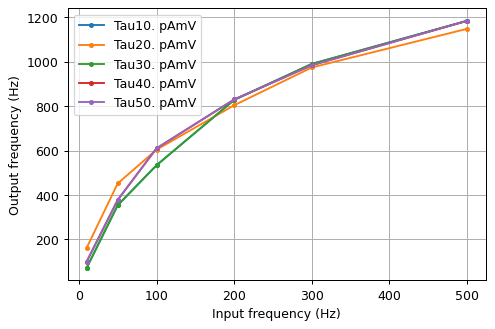

In [ ]:
array_fr=np.array(firing_rate)
for i in range(len(firing_rate)):
    plot(freq_list, array_fr[i], ".-",label='Tau'+str(tau_list[i])+'mV')
    grid()
    

xlabel('Input frequency (Hz)')
ylabel('Output frequency (Hz)')
legend(loc='best')
show()


This is the end of Part 1.